<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dara Loading and Preprocessing</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclustions</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# 01 - ***ML for Texts*** - Project for WikiShop

[Nice reading about BERT](https://docs.deeppavlov.ai/en/master/features/models/bert.html)

BERT (Bidirectional Encoder Representations from Transformers) is a Transformer pre-trained on masked language model and next sentence prediction tasks. This approach showed state-of-the-art results on a wide range of NLP tasks in English.

### Project Goal
The project goal is a binary text classification using ML models.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

### Описание данных

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<font color=blue>
    
<b> Полезные ссылки по машинному обучению для текстов</b>
    
Основы Natural Language Processing для текста  — https://habr.com/ru/company/Voximplant/blog/446738/
    
Интересная статья в общем по NLP — https://habr.com/ru/company/oleg-bunin/blog/352614/
    
BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) — https://habr.com/ru/post/487358/
    
В частности, BERT является довольно популярной моделью. Вот еще информация по этой модели:
    
https://habr.com/ru/post/436878/
    
http://jalammar.github.io/illustrated-bert/; https://huggingface.co/docs/transformers/model_doc/bert
    
И другие ссылки: 
    
http://jalammar.github.io/illustrated-word2vec/
    
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    
http://jalammar.github.io/illustrated-transformer/
    
https://colab.research.google.com/drive/1SBha91u6142pW5mSiQOOjJWCCSAFj4HI?usp=sharing    
 
</font>   

In [66]:
# 1 - импорты из стандартной библиотеки
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import re
import warnings

# 2 - импорты сторонних библиотек
from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from tqdm import notebook
from tqdm import tqdm

# 3 - импорты модулей текущего проекта
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 
tqdm.pandas()

<div class="alert alert-warning">
<b>⚠️PEP-8: </b> 
При написании кода, в частности оформлении импорта библиотек, стоит придерживаться стандарта PEP-8:
    
https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html

</div>

## 1 Data Pre-processing

In [2]:
# read the file handling exceptions
try:
    data = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/toxic_comments.csv', index_col=[0])
except FileNotFoundError:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

In [3]:
# https://code.s3.yandex.net/datasets/toxic_comments.csv

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.toxic.unique()

array([0, 1])

In [6]:
# проверка на пропуски в таргете
data['toxic'].isna().sum()

0

In [7]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

### ***Вывод:*** Видим, что таргет не сбалансирован. Это нужно учесть при подготовке обучающей выборки. Так как для наилучшего обучения модели целевое значение должно быть сбалансировано.

### 1.1 Creating a dictionary for 'stopwords'

In [8]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliabezginova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2 Переведём тексты в стандартный для Python формат: кодировку Unicode U (для русских текстов, для английских - НЕ требуется).

In [9]:
# Изменим кодировку методом astype():
# corpus = data['text'].values.astype('U')
# corpus = data['text']
# corpus_train = X_train.values.astype('U')
# corpus_test = X_test.values.astype('U')

### 1.3 Создадим функцию для лемматизации и очистки текста

Лемматизатор Mystem подходит только для русского языка. Вместо него можно применить, например ***WordNetLemmatizer().***

Пример кода можно взять из тренажера. Лемматизацию мы должны применять к каждому токену (слову в тексте):

```
lemm_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())

```

In [10]:
corpus = list(data['text'])

In [11]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yuliabezginova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    
    lem_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    
    lem_final = re.sub(r'[^a-zA-Z ]', '', lem_text)
    
    return lem_final.lower()

<div class="alert alert-success">
<b>✔️ Способы лемматизации текста</b>
    
1. Лемматизация с помощью Spacy. Но если делать на всем датасете, может занять 0,5-1 час, в зависимости от возможностей компьютера.
https://spacy.io/ или https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

2. Использовать POS-теги, это сделает лемматизацию точнее:
https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
    
Это занимает больше времени, поэтому можешь проверить локально, на небольшой выборке. 
    
Для контроля времени лемматизации, поскольку процесс длительный, можно применять индикатор прогресса. Различные варианты можно посмотреть здесь: 
    
https://habr.com/ru/post/483400/ 
    
Пример:
    
```
from tqdm import tqdm
tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmatize)

```

</div>

#### Протестируем работу функции лемматизации и очистки текста.

In [13]:
print("Исходный текст:", corpus[100])
print("Очищенный и лемматизированный текст:", lemmatize(corpus[100]))

Исходный текст: However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
Очищенный и лемматизированный текст: however the moonlite edit noted by golden daph wa me on optus  wake up wikkis so funny


#### Применим функцию для лемматизации и очистки текста.

In [14]:
# applying the function without tracking the progress
# data['lem_text'] = data.text.apply(lemmatize)

# lemmatizing with tracking the progress
data['lem_text'] = data['text'].progress_apply(lemmatize)

100%|██████████████████████████████████| 159292/159292 [03:55<00:00, 675.37it/s]


In [15]:
data.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he match this background colour im seemin...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


### 1.4 Разделим данные на тестовую и обучающую выборки

In [16]:
features = data.drop(columns='toxic', axis=1)
target = data['toxic']

In [17]:
features.shape

(159292, 2)

In [18]:
target.shape

(159292,)

In [19]:
# Разделяю на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=5)

In [20]:
print('Train features sample size:', X_train.shape[0])
print('Train target sample size:', y_train.shape[0])
print()
print('Test features sample size:', X_test.shape[0])
print('Test target sample size:', y_test.shape[0])
print()
print('Test sample, %:', round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]) * 100, 2))

Train features sample size: 127433
Train target sample size: 127433

Test features sample size: 31859
Test target sample size: 31859

Test sample, %: 20.0


### Проведем upsampling для корректировки дисбаланса таргетов в обучающей выборке

In [21]:
# функция upsample для создания сбалансированности выборки 
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=5)
    
    return features_upsampled, target_upsampled

In [22]:
# upsample for target disbalance correction
X_train_up, y_train_up = upsample(X_train,
                                  y_train,
                                  repeat = 5)

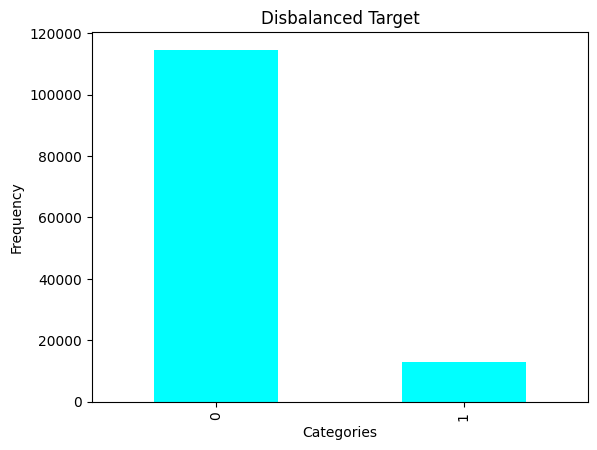

In [39]:
y_train.value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

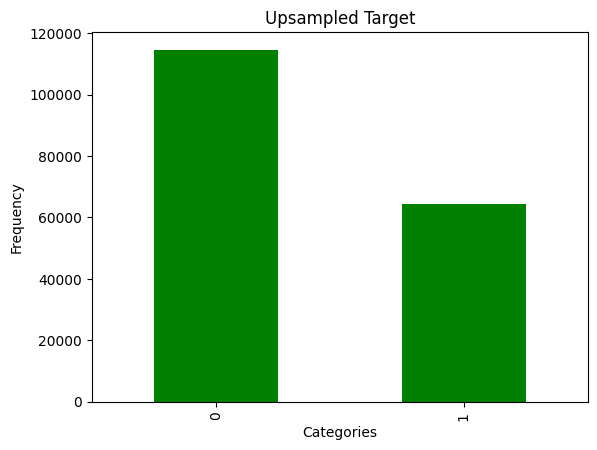

In [40]:
y_train_up.value_counts().plot(kind='bar', color='green')

plt.title('Upsampled Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

#### Таргетные значения теперь сбалансированы лучше, что положительно скажется на обучении.

### ВЫВОД: Исходные данные разделены на тестовые и обучающие, выделены признаки и таргетные значения. Учтен дисбаланс целевых значений на обучающей выборке, проведен upsampling.

Применим модели "мешка слов" к набору данных.

### 1.5 Реализуем модель «мешка слов» в классе CountVectorizer

Мы импортируем класс CountVectorizer, создам экземпляр класса и подгоняем модель к нашим данным для анализа тональности твитов.

In [44]:
vect = CountVectorizer(stop_words=stopwords)

In [45]:
# Считаю Tf-idf для обучающей
X_train_vect = vect.fit_transform(X_train.lem_text)

# Считаю Tf-idf для тестовой
X_test_vect = vect.transform(X_test.lem_text)

Перед тем как мы пытаемся улучшить выделение признаков, давайте измерим качество модели, построив классификатор. 

У нас есть обучающие метки, хранящиеся в y_train и обучающие данные, представленные в виде «мешка слов» X_train, таким образом, мы можем обучить классификатор по этим данным. 

Как правило, для подобных высокоразмерных разреженных данных лучше всего работают линейные модели типа LogisticRegression.

### 1.6 Масштабирование признаков с помощью TF-IDF

Следующий подход вместо исключения несущественных признаков пытается масштабировать признаки в зависимости от степени их информативности. Одним из наиболее распространенных способов такого масштабирования является метод частота термина-обратная частота документа (term frequency-inverse document frequency, tf-idf). 

**Идея этого метода заключается в том, чтобы присвоить большой вес термину, который часто встречается в конкретном документе, но при этом редко встречается в остальных документах корпуса. Если слово часто появляется в конкретном документе, но при этом редко встречается в остальных документах, оно, вероятно, будет описывать содержимое этого документа лучше.**

Мешок слов учитывает частоту употребления слов. Посмотрим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

#### TFIDF = TF * IDF

IDF нужна в формуле, чтобы уменьшить вес слов, наиболее
распространённых в любом другом тексте заданного корпуса.
IDF зависит от общего числа текстов в корпусе (D) и количества
текстов, в которых это слово встречается (d).

Большая величина TF-IDF говорит об уникальности слова в тексте
по отношению к корпусу. Чем чаще оно встречается в конкретном
тексте и реже в остальных, тем выше значение TF-IDF.

**Если данные разделены на обучающую и тестовую выборки,
функцию fit() запустим только на обучающей. Иначе тестирование
будет нечестным: в модели будут учтены частоты слов из тестовой
выборки.**

Сначала переведем выборки X_train, X_test в векторный вид.


#### Несбалансированная выборка таргетов

In [46]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [47]:
# Считаю Tf-idf для обучающей
tf_idf_X_train = count_tf_idf.fit_transform(X_train['lem_text'])

# Считаю Tf-idf для тестовой
tf_idf_X_test = count_tf_idf.transform(X_test['lem_text'])

In [48]:
print("Размер матрицы TF-IDF X_train:", tf_idf_X_train.shape)
print("Размер матрицы TF-IDF X_test:", tf_idf_X_test.shape)

Размер матрицы TF-IDF X_train: (127433, 191019)
Размер матрицы TF-IDF X_test: (31859, 191019)


#### Сбалансированная выборка таргетов

In [49]:
# Считаю Tf-idf для обучающей
tf_idf_X_train_up = count_tf_idf.fit_transform(X_train_up['lem_text'])

In [50]:
print("Размер матрицы TF-IDF X_train_up:", tf_idf_X_train_up.shape)

Размер матрицы TF-IDF X_train_up: (179009, 191019)


### ВЫВОД: Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

## 2 Обучение

<div class="alert alert-success">
<b>✔️ Pipeline</b>
    
Обычно мы обучаем на выборке train и применяем кросс-валидацию, например GridSearchCV. Но когда используется кросс-валидация, получается, что модель в итоге обучается на всей обучающей выборке и это немного не правильно — происходит утечка данных. 
    
В таких случаях рекомендуется оборачивать конструкцию в Pipeline.
    
https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05
    
https://habr.com/ru/post/538458/
    
Pipeline + GridSearchCV: https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4
    
Таким образом в GridSearchCV можно добавить пайплайн.
    
В данном случае в pipeline можно завести функцию upsampling, tf-idf и модель для машинного обучения.
</div>

### 2.1 Logistic Regression с использованием перекрестной проверки для модели «мешка слов» в классе CountVectorizer()

In [51]:
logreg = LogisticRegression(random_state=5,
                           class_weight='balanced')

In [52]:
param_grid = [
    {'C': [0.01, 0.1, 1, 2, 10, 100], 
     'penalty': ['l1', 'l2']}
]

In [98]:
logreg_grid = GridSearchCV(logreg, 
                           param_grid, 
                           cv=3, 
                           verbose=False, 
                           n_jobs=-1,
                          scoring='f1')

logreg_grid.fit(X_train_vect, y_train)

import warnings 
warnings.filterwarnings('ignore')

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [99]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(logreg_grid.best_score_))
print("Наилучшие параметры: ", logreg_grid.best_params_)

Наилучшее значение перекрестной проверки: 0.75
Наилучшие параметры:  {'C': 1}


In [100]:
y_pred_vect = logreg_grid.predict(tf_idf_X_train)

In [101]:
confusion_matrix(y_pred_vect, y_train)

array([[114086,   3746],
       [   453,   9148]])

### ***Вывод:*** Полученная confusion_matrix представляет собой массив размером 2x2, где строки соответствуют фактическим классам, а столбцы соответствуют спрогнозированным классам. В данном случае речь идет о классах 0 и 1, то есть нетоксичный (0) и токсичный (1) комментарий.

Число в каждой ячейке показывает количество примеров, когда спрогнозированный класс, представленный столбцом, совпадает или не совпадает с фактическим классом, представленным строкой.

#### В полученной матрице видим, что элементы главной диагонали (28553 --> 0, 2011 --> 1) соответствуют правильным прогнозам (результатам классификации), тогда как остальные элементы показывают, сколько примеров, относящихся к одному классу, были ошибочно классифицированы как другой класс.

**Получается, что фактический класс 0 (28553) и спрогнозированный класс 0 (14) прогнозируется довольно точно. В то время, как фактический класс 1 (1281) прогнозируется с низкой точностью: только 1281 класс действительно является классом 1 из 2011 наблюдений, тогда как 2011 - ложно положительны. Эту модель точно нельзя рекомендовать к использованию.**

### 2.2 Logistic Regression с использованием решетчатого поиска для модели «мешка слов» в классе TfidfVectorizer()

Поскольку tf-idf фактически использует статистические свойства
обучающих данных, мы воспользуемся конвейером, чтобы убедиться в достоверности результатов решетчатого поиска.

#### Обучим модель на несбалансированной выборке таргетов

In [102]:
logreg_tfidf = LogisticRegression(random_state=5,
                                 class_weight='balanced')

In [104]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(logreg_tfidf, 
                    param_grid, 
                    cv=3,
                   scoring='f1')

grid.fit(tf_idf_X_train, y_train)

import warnings 
warnings.filterwarnings('ignore')

In [60]:
y_pred_tfidf = grid.predict(tf_idf_X_train)

In [61]:
confusion_matrix(y_pred_tfidf, y_train)

array([[112332,     48],
       [  2207,  12846]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а миноритарный дает больше половины ложноположительной ответов FP=1026.

#### Обучим модель на сбалансированной выборке таргетов

In [65]:
logreg_tfidf_up = LogisticRegression(random_state=5)

param_grid_up = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_up = GridSearchCV(logreg_tfidf_up, 
                    param_grid_up, 
                    cv=3,
                   scoring='f1')

grid_up.fit(tf_idf_X_train_up, y_train_up)

import warnings 
warnings.filterwarnings('ignore')

In [129]:
y_pred_tfidf_up = grid_up.predict(tf_idf_X_train)
confusion_matrix(y_pred_tfidf, y_train)

array([[28282,  1026],
       [  285,  2266]])

### ***Вывод:*** Видим, что балансировка классов не улучшила качество обучения модели: число ложно положительных ответов по-прежнему высокое FP=1026, однако мажоритарный класс предсказывается хорошо. Обратим внимание, какое значение F1-меры показал алгоритм на сбалансированной выборке.

### 2.3 CatBoost в модели "мешка слов" в классе TfidfVectorizer()

#### Обучим модель на несбалансированной выборке таргетов

In [81]:
catboost = CatBoostClassifier(random_seed=5,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations':[40], 
                  'learning_rate': np.arange(0.1,1,0.2)}

gsearch_catboost = GridSearchCV(catboost, 
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                               scoring='f1')

gsearch_catboost.fit(tf_idf_X_train, y_train)

import warnings 
warnings.filterwarnings('ignore')

0:	learn: 0.5933380	total: 3.44s	remaining: 2m 14s
1:	learn: 0.5175725	total: 4.81s	remaining: 1m 31s
2:	learn: 0.4577321	total: 6.03s	remaining: 1m 14s
3:	learn: 0.4124881	total: 7.58s	remaining: 1m 8s
4:	learn: 0.3776291	total: 9.26s	remaining: 1m 4s
5:	learn: 0.3478793	total: 10.9s	remaining: 1m 1s
6:	learn: 0.3246453	total: 12.2s	remaining: 57.4s
7:	learn: 0.3068377	total: 13.4s	remaining: 53.6s
8:	learn: 0.2921749	total: 14.6s	remaining: 50.4s
9:	learn: 0.2791147	total: 16.1s	remaining: 48.2s
10:	learn: 0.2697044	total: 17.5s	remaining: 46.2s
11:	learn: 0.2619188	total: 18.8s	remaining: 43.8s
12:	learn: 0.2555392	total: 20s	remaining: 41.5s
13:	learn: 0.2499542	total: 21.3s	remaining: 39.6s
14:	learn: 0.2454003	total: 23.1s	remaining: 38.5s
15:	learn: 0.2415229	total: 25.4s	remaining: 38s
16:	learn: 0.2379865	total: 27.1s	remaining: 36.6s
17:	learn: 0.2347276	total: 28.4s	remaining: 34.7s
18:	learn: 0.2322673	total: 29.9s	remaining: 33s
19:	learn: 0.2292300	total: 31.4s	remaining:

3:	learn: 0.2556833	total: 5.66s	remaining: 51s
4:	learn: 0.2387147	total: 6.89s	remaining: 48.3s
5:	learn: 0.2293371	total: 8.12s	remaining: 46s
6:	learn: 0.2227093	total: 9.43s	remaining: 44.5s
7:	learn: 0.2174192	total: 10.6s	remaining: 42.4s
8:	learn: 0.2126394	total: 11.9s	remaining: 40.8s
9:	learn: 0.2093301	total: 13s	remaining: 39.1s
10:	learn: 0.2057444	total: 14.2s	remaining: 37.5s
11:	learn: 0.2030823	total: 15.4s	remaining: 35.9s
12:	learn: 0.2006431	total: 16.6s	remaining: 34.4s
13:	learn: 0.1984051	total: 17.8s	remaining: 33s
14:	learn: 0.1946389	total: 19.1s	remaining: 31.8s
15:	learn: 0.1925636	total: 20.3s	remaining: 30.5s
16:	learn: 0.1901323	total: 21.5s	remaining: 29.1s
17:	learn: 0.1879302	total: 22.7s	remaining: 27.8s
18:	learn: 0.1863549	total: 23.9s	remaining: 26.4s
19:	learn: 0.1844847	total: 25.1s	remaining: 25.1s
20:	learn: 0.1832741	total: 26.3s	remaining: 23.8s
21:	learn: 0.1818297	total: 27.5s	remaining: 22.5s
22:	learn: 0.1805295	total: 28.7s	remaining: 2

6:	learn: 0.2028042	total: 9.44s	remaining: 44.5s
7:	learn: 0.1985961	total: 10.7s	remaining: 42.7s
8:	learn: 0.1947930	total: 11.9s	remaining: 41s
9:	learn: 0.1909380	total: 13.7s	remaining: 41.1s
10:	learn: 0.1864864	total: 15.3s	remaining: 40.3s
11:	learn: 0.1837110	total: 16.6s	remaining: 38.8s
12:	learn: 0.1813016	total: 17.8s	remaining: 37s
13:	learn: 0.1790961	total: 19.2s	remaining: 35.7s
14:	learn: 0.1762766	total: 20.6s	remaining: 34.4s
15:	learn: 0.1742943	total: 21.8s	remaining: 32.7s
16:	learn: 0.1725091	total: 23.1s	remaining: 31.3s
17:	learn: 0.1707507	total: 24.5s	remaining: 30s
18:	learn: 0.1686719	total: 25.8s	remaining: 28.5s
19:	learn: 0.1675496	total: 27.1s	remaining: 27.1s
20:	learn: 0.1659958	total: 28.2s	remaining: 25.6s
21:	learn: 0.1640136	total: 29.4s	remaining: 24.1s
22:	learn: 0.1624521	total: 30.6s	remaining: 22.6s
23:	learn: 0.1608197	total: 32s	remaining: 21.3s
24:	learn: 0.1597076	total: 33.3s	remaining: 20s
25:	learn: 0.1584431	total: 34.8s	remaining: 

9:	learn: 0.1716666	total: 12.2s	remaining: 36.7s
10:	learn: 0.1683999	total: 13.4s	remaining: 35.2s
11:	learn: 0.1659729	total: 14.5s	remaining: 33.8s
12:	learn: 0.1635707	total: 15.6s	remaining: 32.4s
13:	learn: 0.1611274	total: 16.8s	remaining: 31.1s
14:	learn: 0.1575093	total: 18s	remaining: 30s
15:	learn: 0.1557665	total: 19.1s	remaining: 28.7s
16:	learn: 0.1537733	total: 20.3s	remaining: 27.4s
17:	learn: 0.1523189	total: 21.4s	remaining: 26.2s
18:	learn: 0.1502122	total: 22.7s	remaining: 25.1s
19:	learn: 0.1489838	total: 23.8s	remaining: 23.8s
20:	learn: 0.1473350	total: 25s	remaining: 22.6s
21:	learn: 0.1461934	total: 26.1s	remaining: 21.4s
22:	learn: 0.1452004	total: 27.2s	remaining: 20.1s
23:	learn: 0.1438480	total: 28.4s	remaining: 18.9s
24:	learn: 0.1423177	total: 29.6s	remaining: 17.7s
25:	learn: 0.1415840	total: 30.7s	remaining: 16.5s
26:	learn: 0.1404310	total: 31.9s	remaining: 15.4s
27:	learn: 0.1396061	total: 33s	remaining: 14.2s
28:	learn: 0.1387042	total: 34.2s	remain

In [ ]:
y_pred_catboost = gsearch_catboost.predict(tf_idf_X_train)
confusion_matrix(y_pred_catboost, y_train)

#### Обучим модель на сбалансированной выборке таргетов

In [82]:
catboost_up = CatBoostClassifier(random_seed=5,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat_up = {'iterations':[40], 
                  'learning_rate': np.arange(0.1,1,0.2)}

gsearch_catboost_up = GridSearchCV(catboost_up, 
                                param_grid=parameters_cat_up,
                                cv=3,
                                verbose=False,
                               scoring='f1')

gsearch_catboost_up.fit(tf_idf_X_train_up, y_train_up)

import warnings 
warnings.filterwarnings('ignore')

0:	learn: 0.6448877	total: 2.65s	remaining: 1m 43s
1:	learn: 0.6099469	total: 4.44s	remaining: 1m 24s
2:	learn: 0.5850476	total: 5.87s	remaining: 1m 12s
3:	learn: 0.5647120	total: 7.35s	remaining: 1m 6s
4:	learn: 0.5505686	total: 8.94s	remaining: 1m 2s
5:	learn: 0.5349668	total: 10.5s	remaining: 59.6s
6:	learn: 0.5228325	total: 12s	remaining: 56.3s
7:	learn: 0.5131848	total: 13.5s	remaining: 53.8s
8:	learn: 0.5050681	total: 14.9s	remaining: 51.3s
9:	learn: 0.4970310	total: 16.3s	remaining: 48.8s
10:	learn: 0.4901585	total: 17.6s	remaining: 46.3s
11:	learn: 0.4825240	total: 18.9s	remaining: 44s
12:	learn: 0.4775355	total: 20.2s	remaining: 42s
13:	learn: 0.4724637	total: 21.6s	remaining: 40s
14:	learn: 0.4679101	total: 22.9s	remaining: 38.2s
15:	learn: 0.4614663	total: 24.2s	remaining: 36.3s
16:	learn: 0.4572459	total: 25.6s	remaining: 34.7s
17:	learn: 0.4532161	total: 27.1s	remaining: 33.1s
18:	learn: 0.4499650	total: 28.4s	remaining: 31.4s
19:	learn: 0.4463829	total: 29.8s	remaining: 2

3:	learn: 0.4773080	total: 6.78s	remaining: 1m
4:	learn: 0.4591230	total: 8.17s	remaining: 57.2s
5:	learn: 0.4462110	total: 9.54s	remaining: 54s
6:	learn: 0.4368258	total: 10.9s	remaining: 51.3s
7:	learn: 0.4267365	total: 12.2s	remaining: 48.9s
8:	learn: 0.4178859	total: 13.5s	remaining: 46.5s
9:	learn: 0.4092360	total: 14.8s	remaining: 44.4s
10:	learn: 0.4041710	total: 16.1s	remaining: 42.5s
11:	learn: 0.3986186	total: 17.5s	remaining: 40.8s
12:	learn: 0.3937341	total: 18.8s	remaining: 39s
13:	learn: 0.3875237	total: 20s	remaining: 37.2s
14:	learn: 0.3818283	total: 21.4s	remaining: 35.6s
15:	learn: 0.3779406	total: 22.8s	remaining: 34.2s
16:	learn: 0.3736080	total: 24.1s	remaining: 32.6s
17:	learn: 0.3693201	total: 25.5s	remaining: 31.2s
18:	learn: 0.3645021	total: 26.9s	remaining: 29.7s
19:	learn: 0.3616695	total: 28.2s	remaining: 28.2s
20:	learn: 0.3584639	total: 29.5s	remaining: 26.7s
21:	learn: 0.3555191	total: 30.9s	remaining: 25.3s
22:	learn: 0.3526005	total: 32.1s	remaining: 23

6:	learn: 0.3988254	total: 16.1s	remaining: 1m 16s
7:	learn: 0.3875440	total: 18.3s	remaining: 1m 13s
8:	learn: 0.3778755	total: 20s	remaining: 1m 8s
9:	learn: 0.3714219	total: 21.5s	remaining: 1m 4s
10:	learn: 0.3621993	total: 23s	remaining: 1m
11:	learn: 0.3568868	total: 24.5s	remaining: 57.2s
12:	learn: 0.3509940	total: 26.1s	remaining: 54.2s
13:	learn: 0.3466125	total: 27.5s	remaining: 51s
14:	learn: 0.3424752	total: 28.9s	remaining: 48.1s
15:	learn: 0.3391199	total: 30.2s	remaining: 45.3s
16:	learn: 0.3351405	total: 31.7s	remaining: 42.9s
17:	learn: 0.3320369	total: 33.2s	remaining: 40.5s
18:	learn: 0.3292563	total: 34.9s	remaining: 38.6s
19:	learn: 0.3257897	total: 36.6s	remaining: 36.6s
20:	learn: 0.3222366	total: 38.1s	remaining: 34.5s
21:	learn: 0.3194147	total: 39.6s	remaining: 32.4s
22:	learn: 0.3164951	total: 40.9s	remaining: 30.3s
23:	learn: 0.3141736	total: 42.2s	remaining: 28.2s
24:	learn: 0.3116573	total: 43.6s	remaining: 26.2s
25:	learn: 0.3091324	total: 45s	remaining:

9:	learn: 0.3365592	total: 13.6s	remaining: 40.9s
10:	learn: 0.3289840	total: 14.9s	remaining: 39.3s
11:	learn: 0.3226600	total: 16.3s	remaining: 38.1s
12:	learn: 0.3172882	total: 17.7s	remaining: 36.8s
13:	learn: 0.3127674	total: 18.9s	remaining: 35.2s
14:	learn: 0.3081563	total: 20.2s	remaining: 33.6s
15:	learn: 0.3042548	total: 21.4s	remaining: 32.1s
16:	learn: 0.3009788	total: 22.7s	remaining: 30.6s
17:	learn: 0.2974412	total: 23.9s	remaining: 29.2s
18:	learn: 0.2936301	total: 25.1s	remaining: 27.8s
19:	learn: 0.2902383	total: 26.4s	remaining: 26.4s
20:	learn: 0.2864208	total: 27.7s	remaining: 25.1s
21:	learn: 0.2837553	total: 28.9s	remaining: 23.7s
22:	learn: 0.2812532	total: 30.2s	remaining: 22.3s
23:	learn: 0.2780215	total: 31.4s	remaining: 21s
24:	learn: 0.2753011	total: 32.7s	remaining: 19.6s
25:	learn: 0.2734624	total: 33.9s	remaining: 18.3s
26:	learn: 0.2715408	total: 35.1s	remaining: 16.9s
27:	learn: 0.2689882	total: 36.4s	remaining: 15.6s
28:	learn: 0.2668136	total: 37.8s	

In [135]:
y_pred_catboost_up = gsearch_catboost_up.predict(tf_idf_X_train)
confusion_matrix(y_pred_catboost_up, y_train)

array([[28264,  1155],
       [  303,  2137]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо (FN=303), в то время, как миноритарный класс показывает около 50% ложно положительных ответов.

### 2.4 Gradient Boosting в модели "мешка слова" в классе TfidfVectorizer()

In [87]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [90]:
model = lgb.LGBMClassifier(random_state=5,
                          class_weight='balanced')

In [91]:
params_LGBMClassifier = {    
    
    'n_estimators': [50, 100], 
    'learning_rate': [0.05, 0.1], 
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
#     'random_state' : [5],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model, 
                                     cv=3, 
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(tf_idf_X_train, y_train)

import warnings 
warnings.filterwarnings('ignore')

In [92]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(tf_idf_X_train)
confusion_matrix(y_pred_lightgbm, y_train)

array([[109401,   1991],
       [  5138,  10903]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а вот миноритарный снова дает больше половины ложноположительной ответов FP=1230.

### 2.5 Сравним модели

In [62]:
# Logistic Regression CountVectorizer
best_score_vect = round(logreg_grid.best_score_, 2)
print("Best score Logistic Regression CountVectorizer: {:.2f}".format(best_score_vect))

# f1_logreg_vect = round(f1_score(logreg_grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_vect))

Best score Logistic Regression CountVectorizer: 0.75


In [63]:
# Logistic Regression TF-IDF
best_score_tfidf = round(grid.best_score_, 2)
print('Best score Logistic Regression (TF-IDF): {:.2f}'.format(best_score_tfidf))

# f1_logreg_tfidf = round(f1_score(grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_tfidf))

Best score Logistic Regression (TF-IDF): 0.76


In [77]:
# Logistic Regression TF-IDF (upsampled)
best_score_tfidf_up = round(grid_up.best_score_, 2)
print('Best score Logistic Regression (TF-IDF) upsampled: {:.2f}'.format(best_score_tfidf_up))

Best score Logistic Regression (TF-IDF) upsampled: 0.96


In [83]:
# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 2)
print('Best score CatBoostClassifier (TF-IDF): {}'.format(best_score_catboost))

# f1_catboost = round(f1_score(gsearch_catboost.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_catboost))

Best score CatBoostClassifier (TF-IDF): 0.73


In [84]:
# CatBoost (upsampled)
best_score_catboost_up = round(gsearch_catboost_up.best_score_, 2)
print('Best score CatBoostClassifier (TF-IDF) upsampled: {}'.format(best_score_catboost_up))

Best score CatBoostClassifier (TF-IDF) upsampled: 0.85


In [93]:
# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 2)
print('Best score LGBMClassifier (TF-IDF): {}'.format(best_score_LGBM))

# f1_lgbm = round(f1_score(LGBMClassifier_gsearch.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_lgbm))

Best score LGBMClassifier (TF-IDF): 0.72


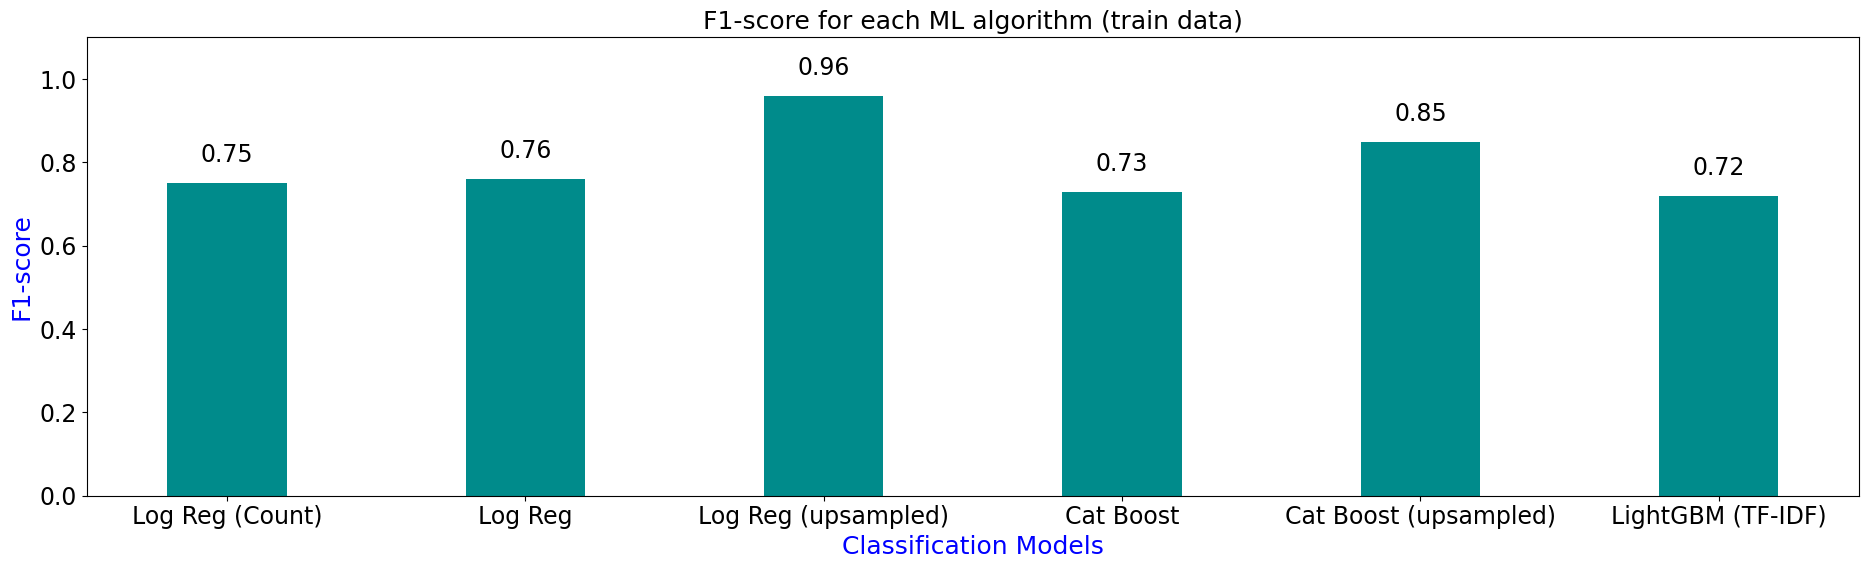

In [105]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17, 
                     'text.color' : 'black', 
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Count)',
     'Log Reg', 
     'Log Reg (upsampled)', 
     
     'Cat Boost',
     'Cat Boost (upsampled)',
     'LightGBM (TF-IDF)']

y = [best_score_vect, 
     best_score_tfidf, 
     best_score_tfidf_up,
     best_score_catboost,
     best_score_catboost_up,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=18)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout();

In [ ]:
# pipe_lr = Pipeline([('vect', CountVectorizer()),
#                    ('tfidf', TfidfTransformer()),
#                 ('clf', LogisticRegression(random_state=5,
#                                           class_weight='balanced'))])

### ***Вывод:*** Максимальное значение F1-меры приходится на модель логистической регрессии (F1-score = 0.96), построенные для модели TD-IDF на выборке с учетом дисбалансов таргетов (upsampled). ***Протестируем оба алгоритма на тестовой выборке.***

## 3 Выводы

### 3.1 F1-score for the best model

In [95]:
# Logistic Regression TF-IDF (upsampled)
f1_logreg_tfidf_test_up = round(f1_score(grid_up.predict(tf_idf_X_test), y_test), 2)
print("F1-score Logistic Regression TF-IDF upsampled (test data): {:.2f}".format(f1_logreg_tfidf_test_up))

F1-score Logistic Regression TF-IDF upsampled (test data): 0.78


In [96]:
y_pred_logreg_up = grid_up.predict(tf_idf_X_test)
confusion_matrix(y_pred_logreg_up, y_test)

array([[27685,   647],
       [  882,  2645]])

### 3.2 Отчет о результатах классификации // Classification report

Функция classification_report печатает отчет, в котором выводятся показатели точности, полноты и f-меры для отрицательного и положительного классов. Миноритарный класс «девятка» считается положительным классом. Значение f-меры для него равно 0. Для мажоритарного класса '0' значение f-меры равно 0.97. Крайний правый столбец – это поддержка (support), которая равна фактическому количеству примеров данного класса.

In [97]:
print('\n', classification_report(y_test, y_pred_logreg_up))


               precision    recall  f1-score   support

           0       0.98      0.97      0.97     28567
           1       0.75      0.80      0.78      3292

    accuracy                           0.95     31859
   macro avg       0.86      0.89      0.87     31859
weighted avg       0.95      0.95      0.95     31859



### ***Вывод:*** Наилучшая модель классификации текста комментариев твиттера - это логистическая регрессия с максимальным значением F1-меры 0.78, построенная на модели "мешка слов". Модель построена после корректировки дисбалансов таргетов методом upsampling. Главная диагональ сonfusion matrix демонстрирует, что модель обучается хорошо: количство ложно пложительных и ложно отрицательных предсказаний менее 20%.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны

***Thank you for going through this project. Your comments are more then welcome to ybezginova2021@gmail.com***

***Best wishes,***

***Yulia***